# Strategy Recommendation for an At-home Trader
By Cassandra Wong

## Introduction

It is fairly common for people to do some trading with their money, either out of interest or to try to make a profit, whether trading stocks, indices, commodities, crypto assets, etc. There has been many simple models to attempt to predict future stock prices using various technical indicator as features. However, one hole is not yet filled. As for an inexperience investor who does not necessarily have a strategy to trade, is it better to swing trade or to invest long term? 

The goal of this notebook is to observe sesonality in stock returns and find the ideal frequency of trading that will provide the most reliable returns for the asset. 

### Solutions Overview:
- Assumptions: this problem assumes that the stock is only traded at the adjusted closing price (price of the stock after paying off dividends), its growth rate is constant, and seasonality is present in the time series data. We ignore some of the fundamental properties such as holiday effects, valuation multiple (P/E) ratio, and economic strength of the market. 
- S&P500 data is retrieved from the `sp500_stocks.csv` file, and the META stock is chosen for this project.
- Data visualization is performed to analyze some of the key properties (adjusted closing price, volume, etc.)
- Seasonal decomposition is used to deconstruct a time series into several components, and to extract the periodic (or seasonal) component in attempt to study its underlying pattern with periods = year, month, and week. While the stock market's seasonal cycle is not reliable every year, it can be powerful over the long term.

## Import Libraries and Dataset

### Libraries and Plot Settings

In [1]:
pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import datetime
import statsmodels.api as sm
from pylab import rcParams
from matplotlib import dates as mdates
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Import and Preprocess Stock Data

The data of the S&P 500 stock (the most famous financial benchmark in the world) is updated daily, and can be obtained from [Kaggle](https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks). 

Data features:
- Date - Timestamp
- Symbol - Company Symbol/Ticker
- Adj Close - Similar to the price at market closure, yet also takes into account company actions such as dividends and splits
- Close - Price at market closure
- High - Maximum value of period
- Low - Minimum value of period
- Open - Price at market opening
- Volume - Volume traded

In [3]:
# S&P500 Data
sp = pd.read_csv('sp500_stocks.csv')
sp['Date'] = sp.Date.astype(str).str[:10]
sp['Date'] = pd.to_datetime(sp['Date'])
sp=sp.set_index('Date')
sp.head()

,Symbol,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2010-01-04,MMM,59.318886,83.019997,83.449997,82.669998,83.089996,3043700.0
2010-01-05,MMM,58.947342,82.500000,83.230003,81.699997,82.800003,2847000.0
2010-01-06,MMM,59.783295,83.669998,84.599998,83.510002,83.879997,5268500.0
2010-01-07,MMM,59.826176,83.730003,83.760002,82.120003,83.320000,4470100.0
2010-01-08,MMM,60.247749,84.320000,84.320000,83.300003,83.690002,3405800.0


Meta went IPO on May 18, 2012. To ensure annuality, only the data from 2013 to 2022 is extracted. 

In [4]:
# Meta stock data
meta = sp[sp['Symbol']=='META']
meta = meta['2013':'2022']
meta.head()

,Symbol,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2013-01-02,META,28.000000,28.000000,28.180000,27.420000,27.440001,69846400.0
2013-01-03,META,27.770000,27.770000,28.469999,27.590000,27.879999,63140600.0
2013-01-04,META,28.760000,28.760000,28.930000,27.830000,28.010000,72715400.0
2013-01-07,META,29.420000,29.420000,29.790001,28.650000,28.690001,83781800.0
2013-01-08,META,29.059999,29.059999,29.600000,28.860001,29.510000,45871300.0


We take a closer look in the adjusted closing price and stock volume over time. 

Text(0, 0.5, 'Percent Change of Adjusted Closing Price (%)')

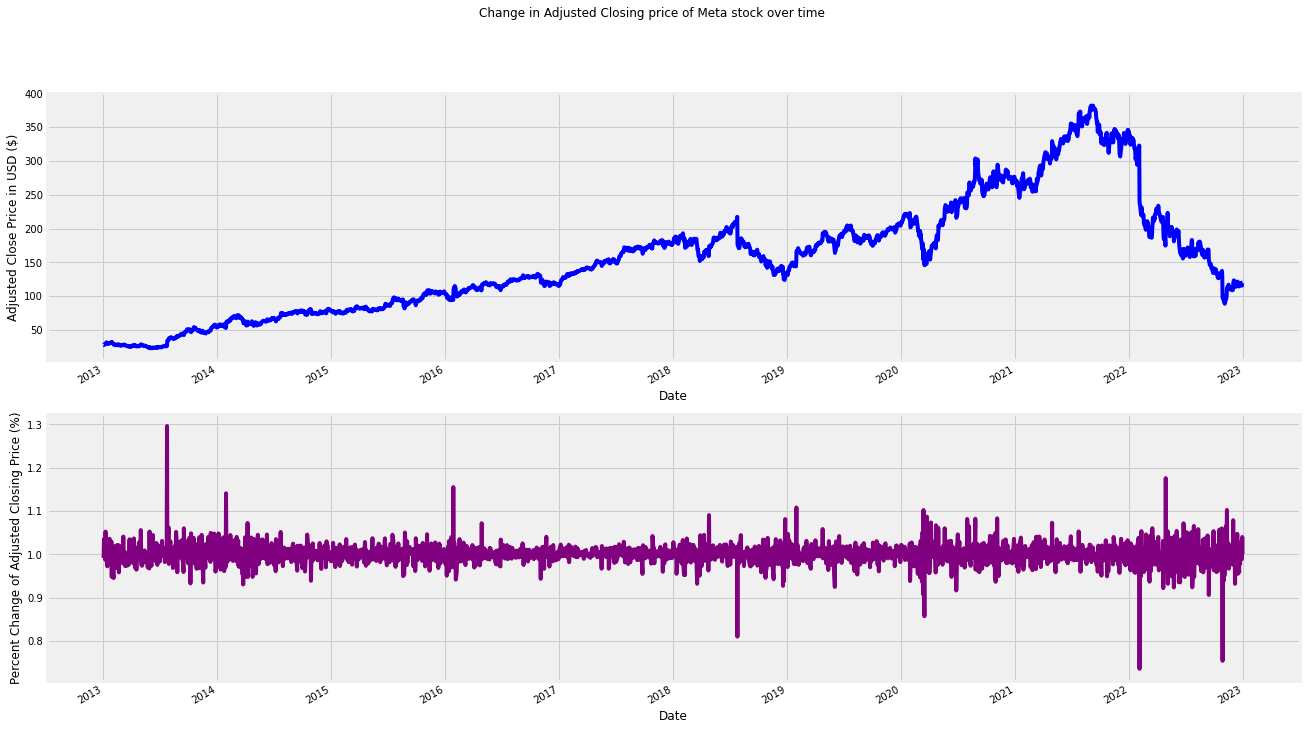

In [5]:
fig, axes = plt.subplots(figsize=(20, 12),nrows=2,ncols=1)
fig.suptitle('Change in Adjusted Closing price of Meta stock over time')

ax1=meta['Adj Close'].plot(color='blue',ax=axes[0])
ax1.set_ylabel('Adjusted Close Price in USD ($)')

meta['Change']=meta['Adj Close'].div(meta['Adj Close'].shift())
ax2=meta['Change'].plot(color='purple',ax=axes[1])
ax2.set_ylabel('Percent Change of Adjusted Closing Price (%)')

The overall trend appears to increase overtime, with a growth spurt happening in mid 2013, and various plunges happening in mid 2018, early 2020, and early 2022. 
The stock value declined in 2022 from \$325 to less than \$90 in November of 2022. It is important to note that the market went down for various reasons, with high inflation rate being the most prominent source of stock market trouble. 

We first determine whether stationarity is present in the time series, such that the time series does not have a trend component. Its statistical properties like mean, variance, covariance do not vary with time. We utilize the Augmented Dickey-Fuller (ADF) test, and the null hypothesis $H_0$ being the time series is non-stationary. With $\alpha=0.05$, if test statistic > critical value, we can reject the null hypothesis, and accept the alternative hypothesis $H_A$, which is that the time series is stationary. 

In [6]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(meta['Adj Close'])
print(result)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

(-1.6686964560088569, 0.44730885744001814, 20, 2497, {'1%': -3.4329715599546646, '5%': -2.862698190651408, '10%': -2.567386549839784}, 14307.814277400139)
ADF Statistic: -1.668696
p-value: 0.447309


Since the test statistic < critical value, and the p value exceeds our stated $\alpha$, we accept the null hypothesis, which is that the time series consists of a trend component. 

In [7]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.668696
p-value: 0.447309


## Seasonality in Time Series

### Seasonal Decomposition

We assume that the time series of META stock returns is stationary (i.e., seasonality does not affect the statistical properties like mean, variance, autocorrelation, etc. are all constant over time). Seasonality is a term to describe a short-term pattern that repeats itself at a fixed frequency. We can use seasonal decomposition to split a time series into 3 components in order to exploit seasonality trends. 

The additive model has the formula: $Y[t] = T[t] + S[t] + e[t]$, where 

- $T[t]$ = Trend -- calculated using a centered moving average of the time series, resulting in a smoothed series 
- $S[t]$ = Seasonal -- the variation that is periodic and repeats itself over a specific time period
- $e[t]$ = Residual -- noise / outliers that is left after removing the trend and seasonal components from the original time series

We assume the seasonal component is constant over a specified period, and various time periods will be tested to see if there is any trend.

### Yearly Seasonality

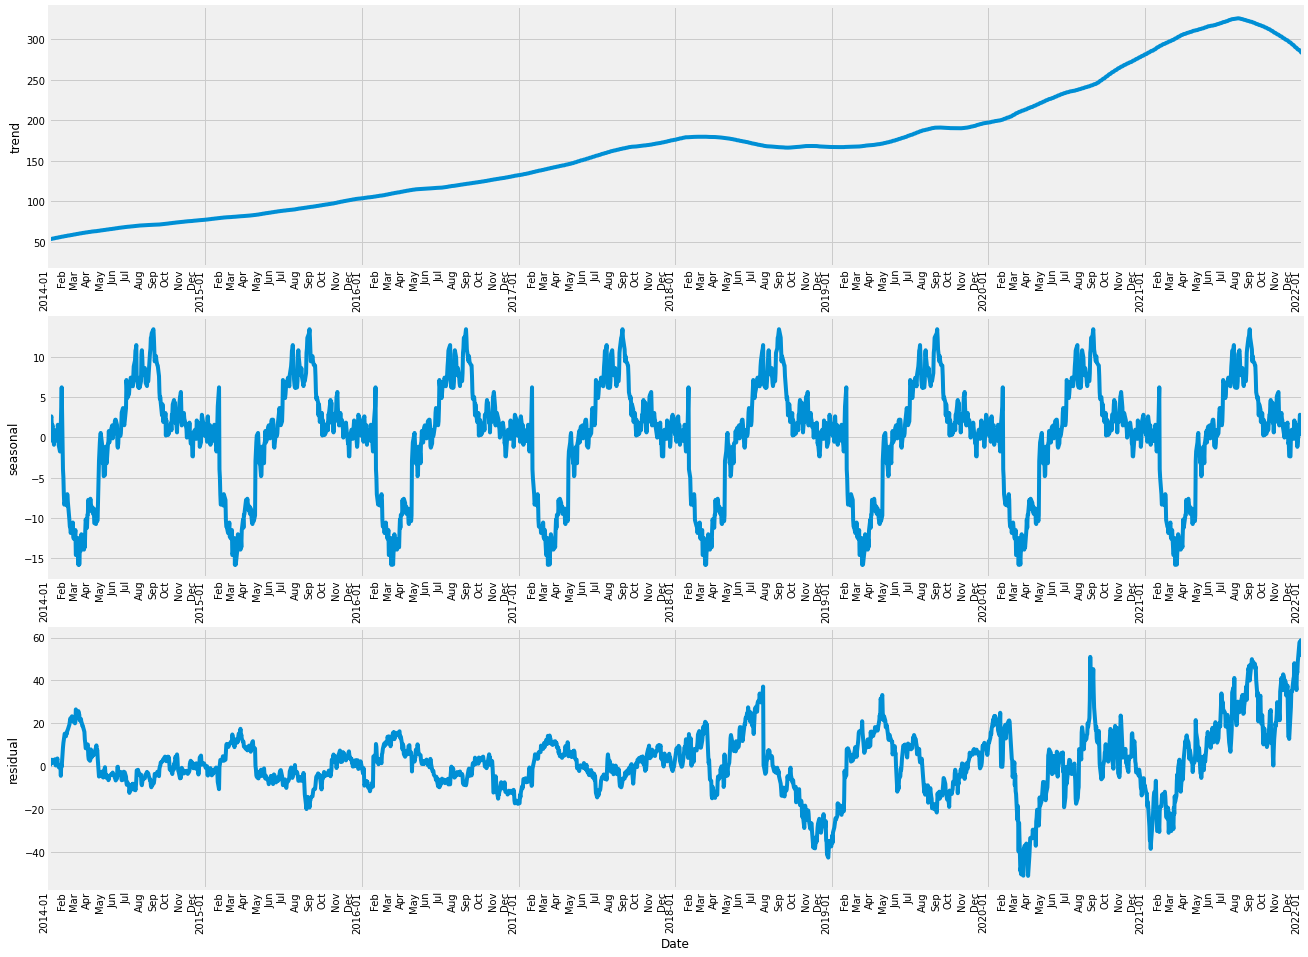

In [8]:
# there are ~252 trading days per year in the US stock and option markets.
decomposed_meta_yearly = sm.tsa.seasonal_decompose(meta['Adj Close'],model='additive',period=252) # annual period

trend_year = decomposed_meta_yearly.trend
seasonal_year = decomposed_meta_yearly.seasonal
residual_year = decomposed_meta_yearly.resid

yearly_meta = pd.DataFrame({"trend":trend_year, "seasonal":seasonal_year,"residual":residual_year})

years = mdates.YearLocator()    # only print label for the years
months = mdates.MonthLocator()  # mark months as ticks
years_fmt = mdates.DateFormatter('%Y-%m')
fmt = mdates.DateFormatter('%b')

_, axes = plt.subplots(nrows=3,ncols=1, figsize=(20, 18))
for i, ax in enumerate(axes):
    ax = yearly_meta.iloc[:,i].plot(ax=ax)
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    ax.xaxis.set_minor_formatter(fmt)
    ax.set_ylabel(yearly_meta.iloc[:,i].name)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
    ax.set_xlim(['2014','2022'])

In [9]:
curr = 2013
seasonal_year_sum=[]

for i in range(10):
    seasonal_year_sum.append({
        'Year':curr,
        'Min Month':seasonal_year[str(curr)].idxmin().month, # find the min month in the seasonal chart
        'Max Month':seasonal_year[str(curr)].idxmax().month # find the max month in the seasonal chart
        })
    curr += 1

seasonal_ysum=pd.DataFrame(seasonal_year_sum)
seasonal_ysum

,Year,Min Month,Max Month
0,2013,3,8
1,2014,3,9
2,2015,3,9
3,2016,3,8
4,2017,3,8
5,2018,3,8
6,2019,3,9
7,2020,3,9
8,2021,3,9
9,2022,3,9


We see that the seasonal trend repeats every year, with major low in March and major high in August and September. Let's dive into the mean stock price in these specific months.

In [10]:
curr_yr = 2013
mar_mean_stock_prices=[]
aug_mean_stock_prices=[]

for i in range(9):
    mar_mean_stock_prices.append('$'+str(meta[str(curr_yr)+'-03']['Adj Close'].mean().round(2)))
    aug_mean_stock_prices.append('$'+str(meta[str(curr_yr)+'-08']['Adj Close'].mean().round(2)))
    curr_yr += 1

print("The mean of March stock price from 2013 to 2022 is")
print(*mar_mean_stock_prices, sep=', ')
print("The mean of August stock price from 2013 to 2022 is")
print(*aug_mean_stock_prices, sep=', ')

The mean of March stock price from 2013 to 2022 is
$26.81, $67.09, $81.01, $110.78, $139.41, $173.49, $167.41, $165.75, $275.51
The mean of August stock price from 2013 to 2022 is
$38.75, $73.97, $91.78, $124.47, $169.16, $177.49, $184.5, $268.79, $363.02


We see that this trend holds true (i.e., stock prices are higher in August than March) for all the years, except in 2022.

### Monthly and Weekly Seasonality
Can we explore other seasonal trends within different periods, such as months and weeks?

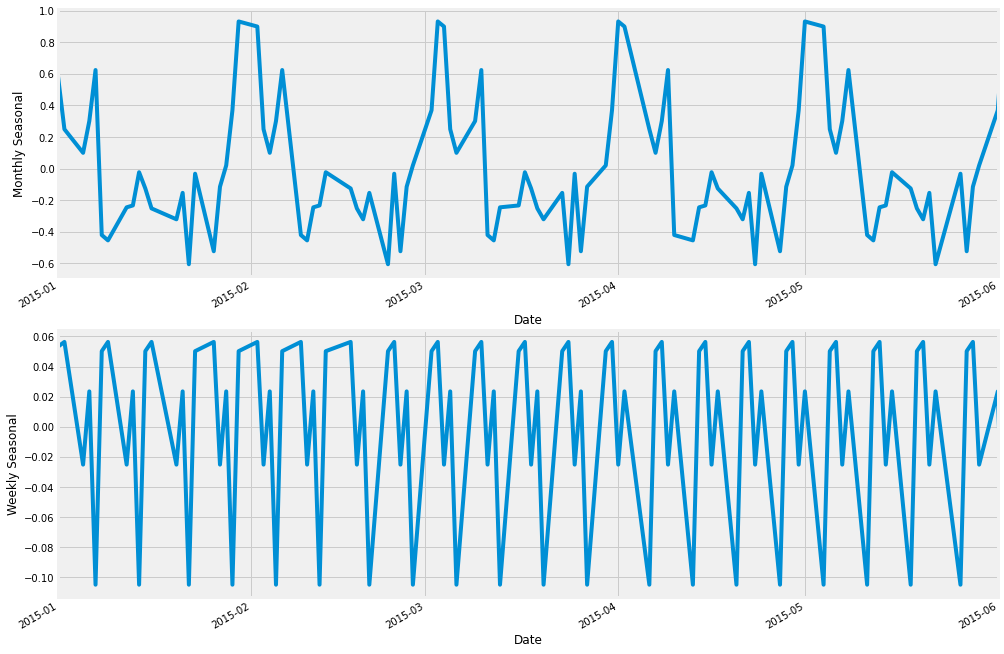

In [11]:
# there are ~21 trading days per month, ~5 trading days per week in the US stock and option markets.

decomposed_meta_monthly = sm.tsa.seasonal_decompose(meta['Adj Close'],model='additive',period=21) # monthly period
decomposed_meta_weekly = sm.tsa.seasonal_decompose(meta['Adj Close'],model='additive',period=5) # weekly period

seasonal_month = decomposed_meta_monthly.seasonal
seasonal_week = decomposed_meta_weekly.seasonal

meta_seasonal = pd.DataFrame({"Monthly Seasonal":seasonal_month, "Weekly Seasonal":seasonal_week})
y_label = ['Monthly Seasonal','Weekly Seasonal']

# label formatting
years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y-%b')
fmt = mdates.DateFormatter('%b')

_, axes = plt.subplots(nrows=2,ncols=1, figsize=(15, 12))
for i, ax in enumerate(axes):
    ax = meta_seasonal.iloc[:,i].plot(ax=ax)
    ax.set_ylabel(y_label[i])
    ax.set_xlim(['2015-01','2015-6'])

Note that only the seasonal pattern from 2015 Jan to 2015 June is shown in the plot above. We observe that the patterns are not as uniform as the annual seasonal chart. We can dive into the seasonality chart by extracting the min and max weekdays from these decompositions. 

Note that 1 = Monday and 5 = Friday.

In [12]:
curr = 1
seasonal_month_sum=[]

for i in range(12):
    seasonal_month_sum.append({
        'Date':'2015-'+str(curr),
        'Min Weekday (Monthly Period)':seasonal_month['2015-'+str(curr)].idxmin().day,
        'Max Weekday (Monthly Period)':seasonal_month['2015-'+str(curr)].idxmax().day,
        'Min Weekday (Weekly Period)':seasonal_week['2015-'+str(curr)].idxmin().isoweekday(),
        'Max Weekday (Weekly Period)':seasonal_week['2015-'+str(curr)].idxmax().isoweekday()
        })
    curr += 1

seasonal_wsum=pd.DataFrame(seasonal_month_sum)
seasonal_wsum

,Date,Min Weekday (Monthly Period),Max Weekday (Monthly Period),Min Weekday (Weekly Period),Max Weekday (Weekly Period)
0,2015-1,22,30,3,5
1,2015-2,23,2,4,1
2,2015-3,24,3,5,2
3,2015-4,23,1,1,3
4,2015-5,22,1,1,3
5,2015-6,23,2,2,4
6,2015-7,23,1,3,4
7,2015-8,21,31,3,5
8,2015-9,22,30,3,5
9,2015-10,21,29,4,1


For the seasonal trend with a monthly period, we observe major low between dates of 19 to 24, with 23 being the most prominent, and major high between dates of 29 and 3, with 30 being the most prominent. However, pattern seems to be stochastic for seasonal trend with a weekly period. Given that the range of their seasonalities, which is between -0.6 to 0.9, and -0.11 to 0.06 respectively, the profitability and risk of this strategy is not the most suitable to a mom-and-pop investor.

We now attempt to isolate the trend observed from earlier (major low in March and major high in August and September) and investigate it further by plotting the META closing stock price in 2018, as well as the 20-day SMA to smooth out the averages. Simple Moving Average (MA) is a technical analysis tool that measures the average of a range of closing stock prices over a specified period. SMAs are often used to determine trend direction. The formula for SMA is: $SMA = \frac{P_1+P_2+...+P_n}{N}$, where $P_n$ denotes the closing stock price at time $n$, and $N$ refers to the number of time points. 

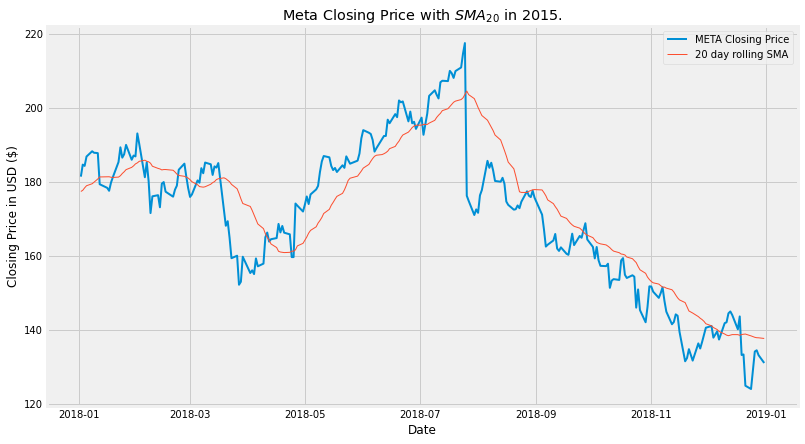

In [13]:
meta['SMA_20'] = meta['Adj Close'].rolling(20).mean().shift()

start='2018-01-01'
end='2018-12-31'

plt.figure(figsize=(12,7))

# plot the adj closing price and SMA_50
plt.plot(meta[start:end]['Adj Close'],label='META Closing Price',linewidth=2)
plt.plot(meta[start:end]['SMA_20'],label='20 day rolling SMA',linewidth=1)

plt.xlabel('Date')
plt.ylabel('Closing Price in USD ($)')
plt.title('Meta Closing Price with $SMA_{20}$ in 2015.')
plt.legend()

plt.show()


The plot shows an example of the observed trend with major low occuring in late 2018 March, and major high in 2018 August. 

## Simple Strategy Based on Seasonality

We test the case where we purchase at first day of the min month (April) and sell at the first day of max month of the following year (September). 

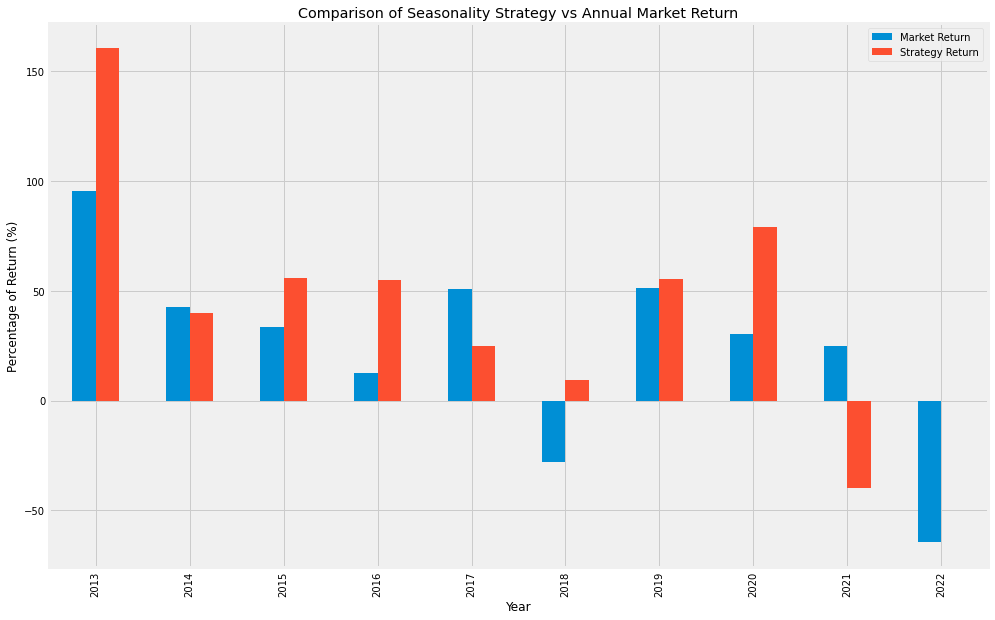

In [14]:
min_mo=seasonal_year.idxmin().month
max_mo=seasonal_year.idxmax().month

idx=yearly_meta.index
years = list(set(idx.year))
years.sort()

strategy_returns = {'Market Return' : pd.Series(index=years),'Strategy Return' : pd.Series(index=years)}
strategy_returnsdf = pd.DataFrame(strategy_returns)

for index, row in strategy_returnsdf.iterrows():
    metadata=meta['Adj Close'][meta['Adj Close'].index.year == index]
    row['Market Return']=((metadata.iloc[-1]-metadata.iloc[0])*100/metadata.iloc[0])
    if index<years[-1]:
        buy=meta['Adj Close'].loc[(meta['Adj Close'].index.year==index) & (meta['Adj Close'].index.month==min_mo)][0]
        sell=meta['Adj Close'].loc[(meta['Adj Close'].index.year==index+1) & (meta['Adj Close'].index.month==max_mo)][0]
        row['Strategy Return']=((sell-buy)/buy)*100

ax = strategy_returnsdf[['Market Return','Strategy Return']].plot(kind='bar', figsize=(15, 10))
ax.set_title("Comparison of Seasonality Strategy vs Annual Market Return")
ax.set_xlabel("Year")
ax.set_ylabel("Percentage of Return (%)")
plt.show()

array([[<AxesSubplot:title={'center':'Market Return'}>,
        <AxesSubplot:title={'center':'Strategy Return'}>]], dtype=object)

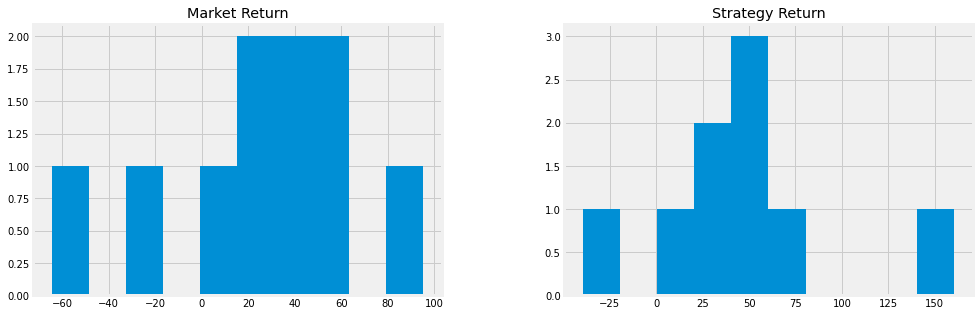

In [15]:
strategy_returnsdf.hist(figsize=(15, 5))

In [16]:
strategy_returnsdf.describe()

,Market Return,Strategy Return
count,10.000000,9.000000
mean,24.910468,48.880450
std,44.269226,54.238728
min,-64.453242,-39.628557
25%,15.679789,24.909035
50%,31.811216,54.671281
75%,48.902519,55.874605
max,95.178577,160.475158


Observations:
- The suggested strategy can provide a mean of 48.89% return, whereas the annual market return has a mean of 24.9%. 
- It is important to note that the strategy return has a larger standard deviation of 54.24 compared to 44.27 with the annual market return.

## Conclusions

### Statistical Analysis
- The EDA portion provides an overview about attributes of the META stock.
- Seasonality of the annual period was analyzed, and found March to be when major low occurs, and August and September to be when major high occurs. 
- This strategy (buying in March and selling in August of the following year) can help an inexperience investor trade to provide the most reliable returns for the asset, such that the strategy return is better than an annual market return by almost 96%.

### Limitations to be improved
- Only the META stock is considered, rather than different market sectors to find correlation in META's seasonality. This seasonality *may* not apply to other stocks.
- The risk of the strategy requires in-depth analysis which is outside of the scope of this assessment.